In [ ]:
import numpy as np
import pandas as pd
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

DATA_PATH = "TFT_Train.csv"
TEST_PATH = "TFT_Test.csv"

train = pd.read_csv(DATA_PATH, parse_dates=["Zeitstempel"])
test  = pd.read_csv(TEST_PATH, parse_dates=["Zeitstempel"])

c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\jonas\AppData\Local\Temp\ipykernel_15992\2749276298.py:16: DtypeWarning: Columns (20,21,40) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(DATA_PATH, parse_dates=["Zeitstempel"])
C:\Users\jonas\AppData\Local\Temp\ipykernel_15992\2749276298.py:17: DtypeWarning: Columns (20,21,40) have mixed types. Specify dtype option on import or set low_memory=False.
  test  = pd.read_csv(TEST_PATH, parse_dates=["Zeitstempel"])


In [ ]:
df = pd.concat([train.assign(split="train"), test.assign(split="test")], ignore_index=True)

df["meter_id"] = df["location_id"]

for part in ("month", "weekday", "hour"):
    df[part] = getattr(df["Zeitstempel"].dt, part).astype(str)

df["is_holiday"] = df["Ferientyp"].notna().astype(str)
df["Ferientyp"]  = df["Ferientyp"].fillna("None").astype(str)
df["post_code"]  = df["post_code"].astype(str)
df["city"]       = df["city"].astype(str)

cat_cols = ["city", "post_code", "Ferientyp", "month", "weekday", "hour", "is_holiday", "Feiertag"]
for c in cat_cols:
    df[c] = pd.Categorical(df[c])               # gemeinsamer Kategorie-Pool

static_categoricals            = ["city", "post_code"]
time_varying_known_categoricals = ["is_holiday", "month", "weekday", "hour"]
time_varying_known_reals        = ["time_idx", "cloud_cover_total", "humidity"]

# 2)  Beim Category-Pool Ferientyp ebenfalls weglassen
cat_cols = ["city", "post_code", "month", "weekday", "hour", "is_holiday", "Wochentag_Name", "Bundesland", "Kreis name", "Ferientyp"]
for c in cat_cols:
    df[c] = pd.Categorical(df[c])

static_reals = [
    "area", "Bruttoverdienst", "Durchschnittsalter der Bevölkerung",
    "Erwerbstätige", "Kaufkraft", "Medianeinkommen",
    "Neubauwohnungen in Ein- und Zweifamilienhäusern",
    "Neubauwohnungen je Einwohner", "Schuldnerquote",
    "Siedlungsdichte in km²"
]

# fehlende numerische Werte füllen
real_fill = ["cloud_cover_total", "humidity"] + static_reals
for col in real_fill:
    if col in df.columns:
        df[col] = (
            df[col]
            .ffill()
            .bfill()
            .fillna(df[col].median())
        )

df = df.drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Kreis code", "Kreis name"]).drop_duplicates()

# Duplikate entfernen
# Kategorische Spalten (first)
cat_cols = [
    'location_id', 'city', 'post_code', 'Datum_Messung', 'Wochentag_Name',
    'Feiertag', 'Bundesland', 'Ferientyp', 'split', 'meter_id',
    'month', 'weekday', 'hour', 'is_holiday', 'dummy_group'
]
# Gruppierspalten
group_cols = ['location_id', 'Zeitstempel']

# Numerische Spalten (mean), außer group_cols
num_cols = df.select_dtypes(include='number').columns.difference(group_cols)

# Aggregations-Logik
agg_dict = {col: 'first' for col in cat_cols if col in df.columns}
agg_dict.update({col: 'mean' for col in num_cols if col in df.columns})

# Gruppierung durchführen
df = (
    df.groupby(group_cols, as_index=False)
      .agg(agg_dict)
)


unique_times = pd.Series(df["Zeitstempel"].unique()).sort_values().reset_index(drop=True)
time_map = {time: idx for idx, time in enumerate(unique_times)}
df["time_idx"] = df["Zeitstempel"].map(time_map)

train = df[df.split == "train"].drop(columns="split")
test  = df[df.split == "test"].drop(columns="split")

In [42]:
max_prediction_length = 24
max_encoder_length = 72
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[df.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Messwert",
    group_ids=["meter_id"],
    static_categoricals=static_categoricals,
    static_reals=static_reals,
    time_varying_known_categoricals=time_varying_known_categoricals,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals      = ["Messwert"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    min_prediction_length=1,
    target_normalizer=GroupNormalizer(
        groups=["meter_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    time_varying_unknown_categoricals=[],
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_encoder_length=True,
    add_target_scales=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=6, persistent_workers=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [43]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\light

0.14226211607456207

In [ ]:
# configure network and trainer
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor("epoch")  # log the learning rate
logger = CSVLogger("logs_csv")  # logging results to a csv file (tensorboard not compatible with python 3.13)

trainer = pl.Trainer(
    max_epochs=50,
    precision='64',
    devices="auto",
    # weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # comment in for training, running validation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.0001,
    hidden_size=32,
    attention_head_size=4,
    lstm_layers=2,
    dropout=0.2,
    hidden_continuous_size=16,
    optimizer="adam",
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # max_encoder_length = max_encoder_length,
    log_interval=1,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 123.2k


c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [52]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 5.0 K  | train
3  | prescalers                         | ModuleDict                      | 576    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 28.5 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 11.0 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 8.9 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K  

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 49: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s, v_num=18, train_loss_step=0.0447, val_loss=0.0646, train_loss_epoch=0.047] 

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s, v_num=18, train_loss_step=0.0447, val_loss=0.0646, train_loss_epoch=0.047]


`Trainer.fit` stopped: `max_epochs=50` reached.
LR finder stopped early after 1500 steps due to diverging loss.
Restoring states from the checkpoint path at c:\Users\jonas\Desktop\Studium\Master\SS 2025\Anwendungsfelder Business Analytics\.lr_find_884e6139-28c7-40f8-9b37-c4a272542ba6.ckpt
Restored all states from the checkpoint at c:\Users\jonas\Desktop\Studium\Master\SS 2025\Anwendungsfelder Business Analytics\.lr_find_884e6139-28c7-40f8-9b37-c4a272542ba6.ckpt
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


suggested learning rate: None


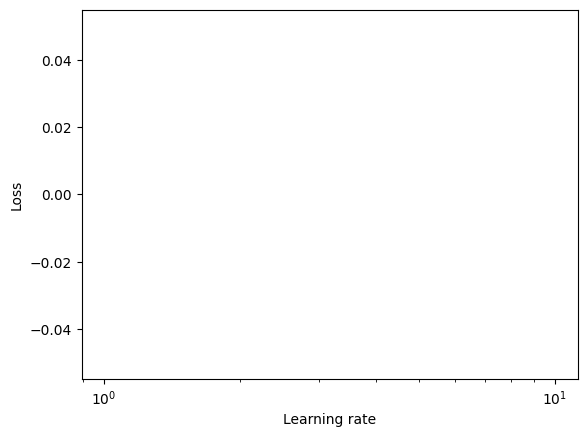

C:\Users\jonas\AppData\Local\Temp\ipykernel_15992\3339402291.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:
from pytorch_lightning.tuner.lr_finder import _lr_find

# find optimal learning rate
res = _lr_find(
    model=tft,
    trainer=trainer,
    max_lr=10.0,
    min_lr=1e-6,
    num_training=100
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()